# Central Bank Policy Rates - BIS

## Python set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandasdmx as sdmx
import datetime as dt
import pycountry
from pathlib import Path

from plotting import (
    finalise_plot,
    set_chart_dir,
    plot_series_highlighted,
)

In [2]:
# plotting set-up
SOURCE = "Source: BIS policy rates"
LFOOTER = "Monthly data. There are lags in BIS data reporting. "
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/BIS/"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
set_chart_dir(CHART_DIR)
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()
SHOW = True

## Data capture

In [3]:
def get_bis_monthly():
    """Get a table of monthly policy rates from the BIS SDMX web service."""

    def country_code_to_name(country_code: str) -> str:
        """Convert 2-digit country codes to country names."""

        try:
            country = pycountry.countries.get(alpha_2=country_code)
            return country.name
        except AttributeError:
            if country_code == 'XM':
                return 'Euro Area'
            return country_code

    def get_bis(conn: sdmx.api.Request, datastr: str, freq: str, start: str) -> pd.DataFrame:
        """Get data from an SDMX web service (conn in the arguments)."""

        datasets = conn.dataflow()
        dataset = [x for x in datasets.dataflow.values() if datastr in str(x.name).lower()][0]
        data = conn.data(
            resource_id=dataset.id,
            key={'FREQ': freq},
            params={'startPeriod': start},
        ).to_pandas().unstack().T
        data.columns = data.columns.droplevel()
        return data

    # Create a connection to the BIS SDMX web service
    conn = sdmx.Request('BIS')

    # Get monthly policy rate data all states
    since = '1996-01'
    monthly_policy_rates = get_bis(conn, 'policy rates monthly', 'M', since)
    monthly_policy_rates.index = pd.PeriodIndex(monthly_policy_rates.index, freq='M')

    # get recent daily policy rates data all states, and convert to monthly
    recent = 90 # days
    start = (dt.datetime.now() - dt.timedelta(days=recent)).strftime('%Y-%m-%d')
    daily_policy_rates = get_bis(conn, 'policy rates daily', 'D', start)
    daily_policy_rates.index = pd.to_datetime(daily_policy_rates.index)
    recent1 = daily_policy_rates.to_period('M')
    recent2 = recent1.groupby(by=[recent1.index.year, recent1.index.month]).ffill()
    recent3 = recent2.groupby(by=[recent2.index.year, recent2.index.month]).last()
    recent3.index.set_names(['year', 'month'], inplace=True)
    recent3.index = pd.PeriodIndex([f'{y}-{m}' for y, m in recent3.index], freq='M')

    # amalgamate the monthly and daily dataframes, as monthly data
    columns = monthly_policy_rates.columns.intersection(recent3.columns)
    index = monthly_policy_rates.index.union(recent3.index)
    monthly_policy_rates = monthly_policy_rates.reindex(index=index)
    recent3 = recent3.reindex(index)
    monthly_policy_rates = monthly_policy_rates[columns]
    monthly_policy_rates = monthly_policy_rates.where(monthly_policy_rates.notna(), other=recent3)
    monthly_policy_rates.columns = [country_code_to_name(c) for c in monthly_policy_rates.columns]

    return monthly_policy_rates    


policy_rates = get_bis_monthly()

## Plotting

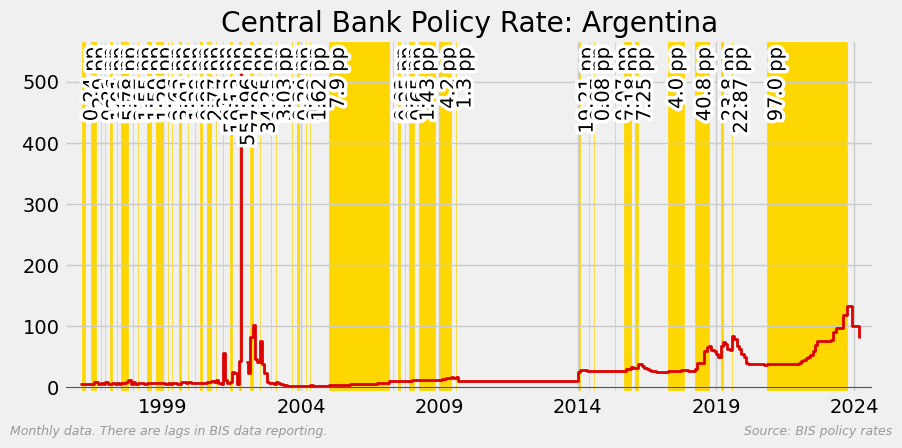

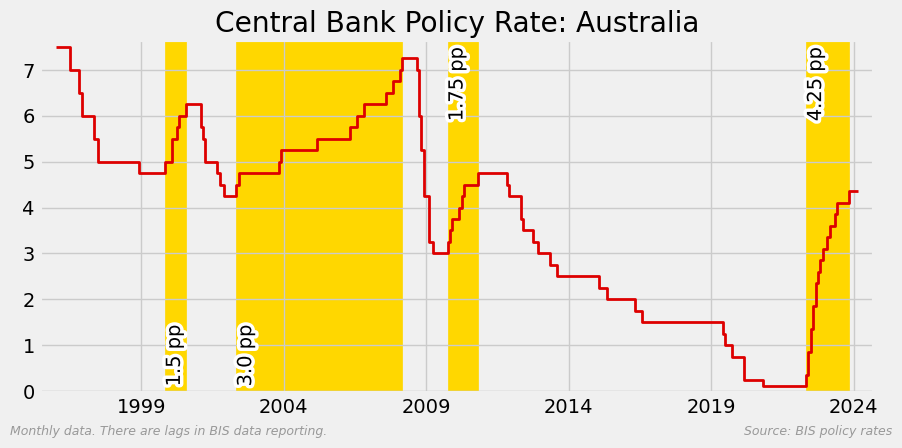

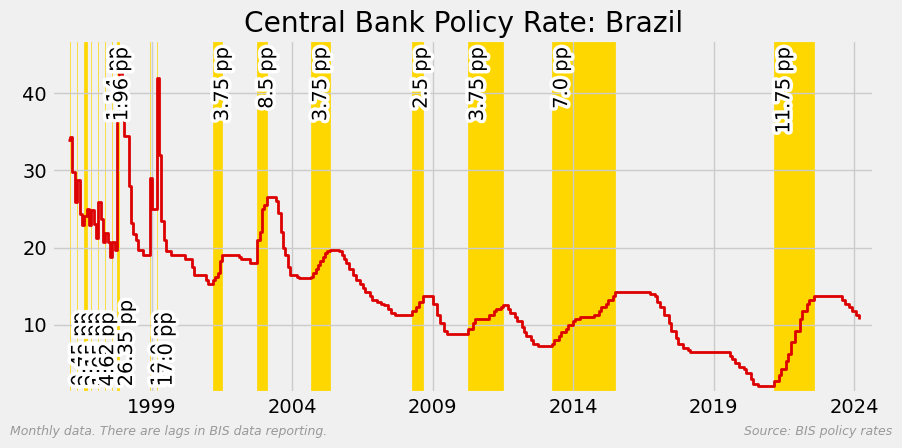

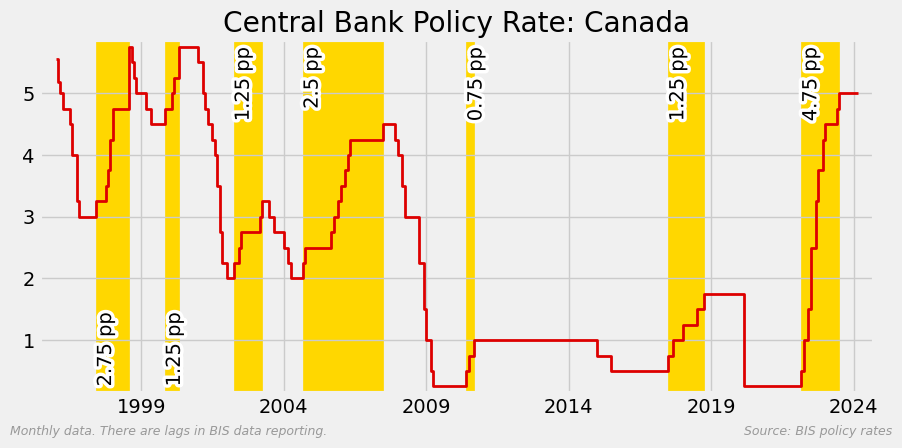

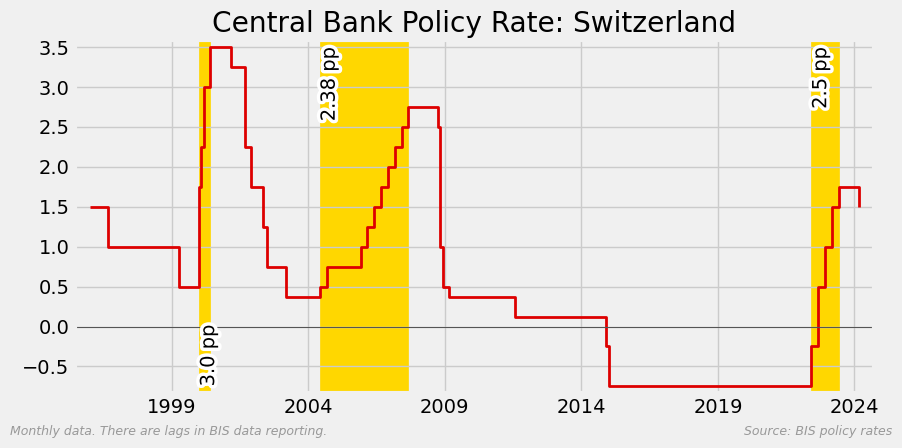

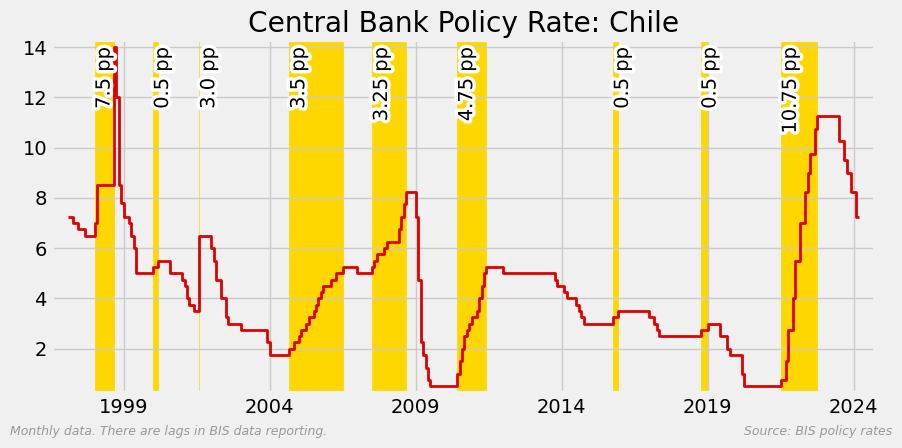

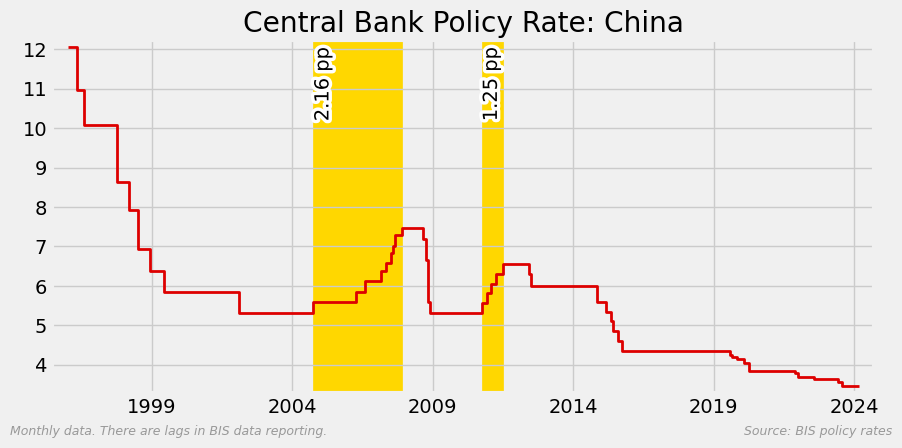

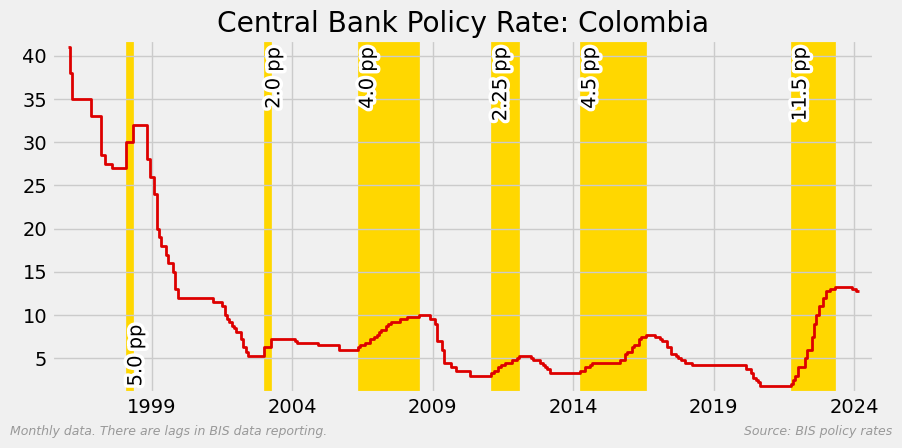

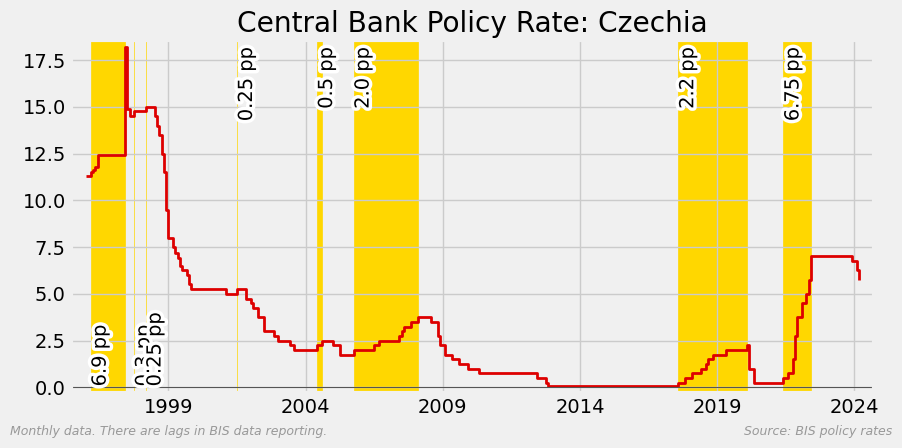

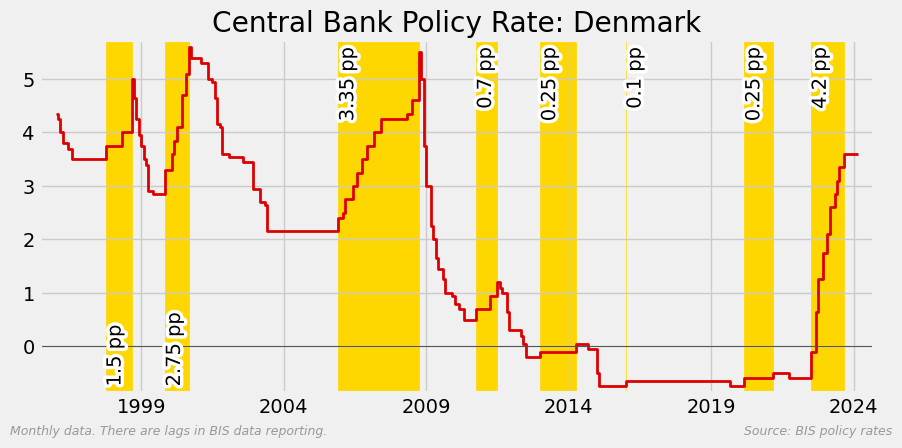

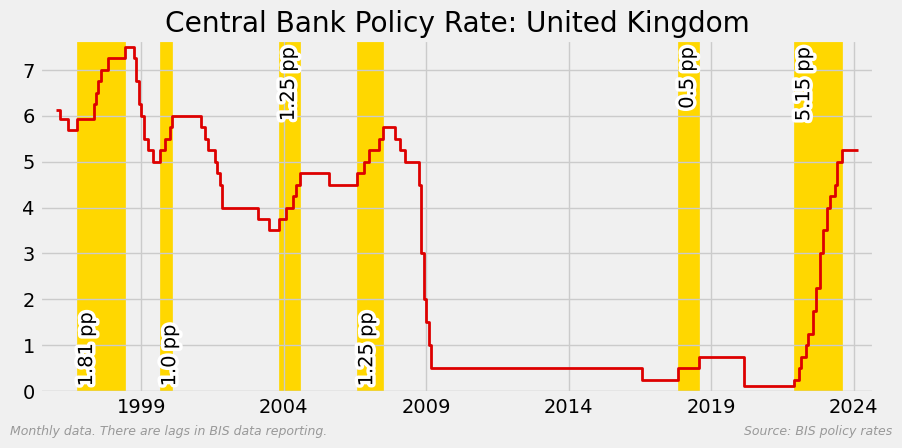

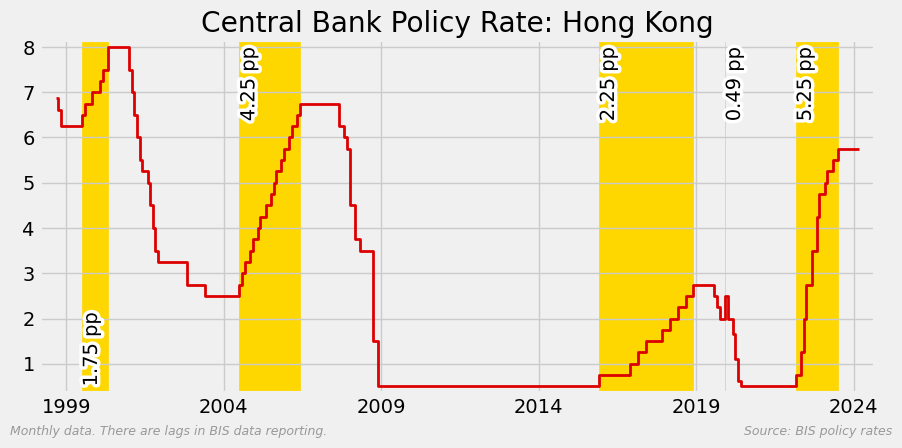

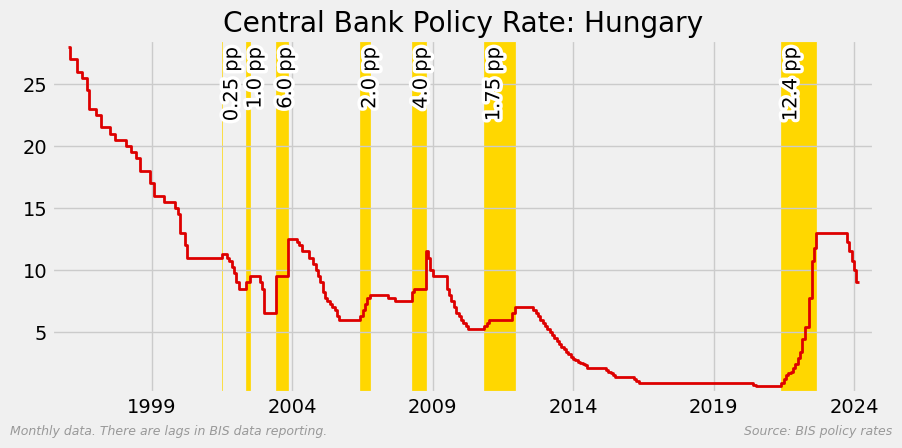

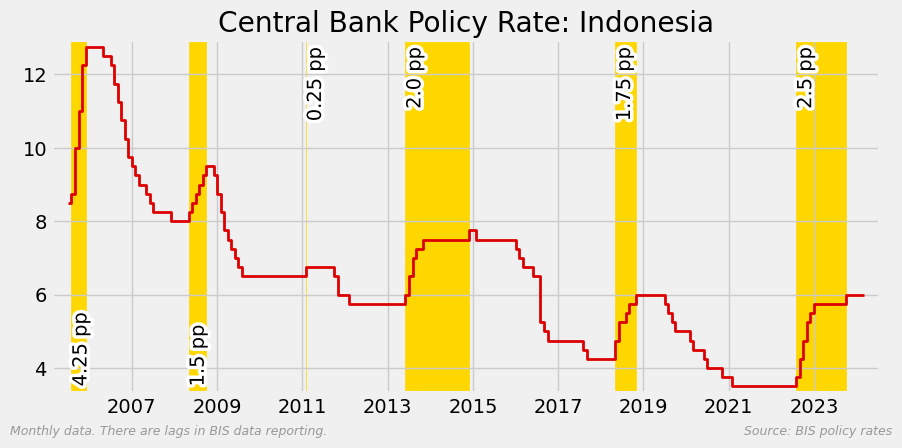

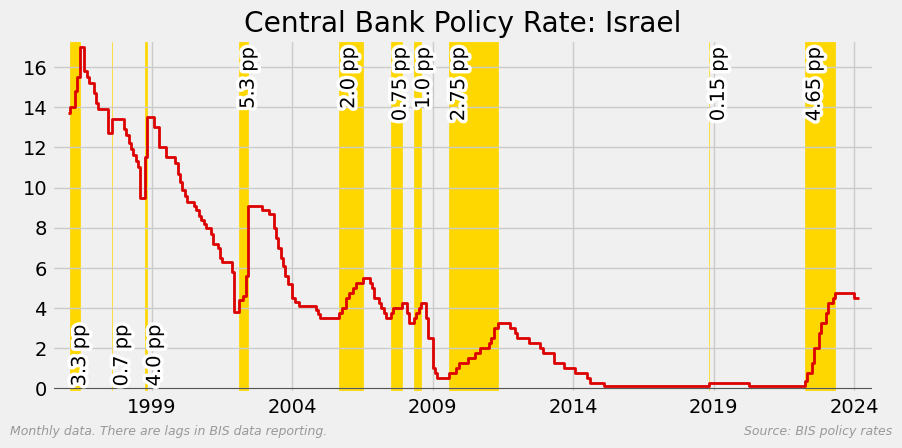

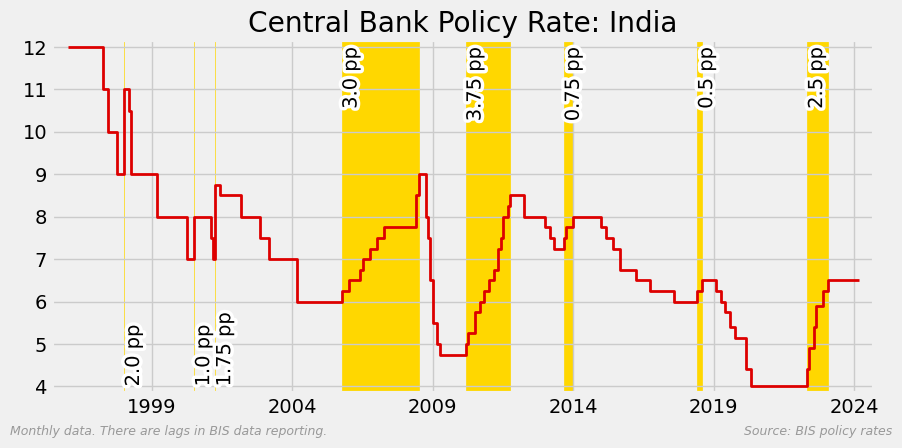

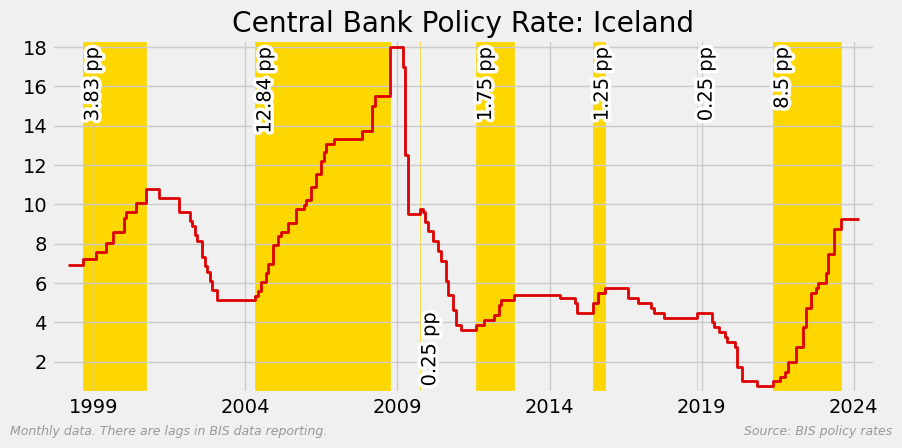

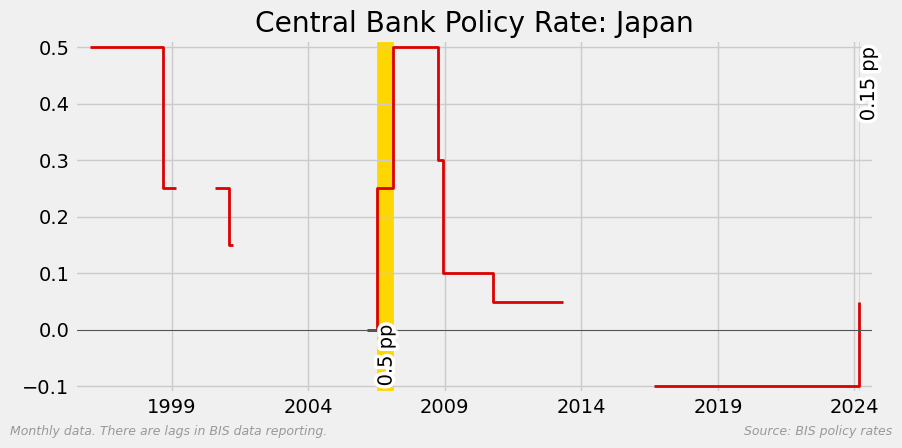

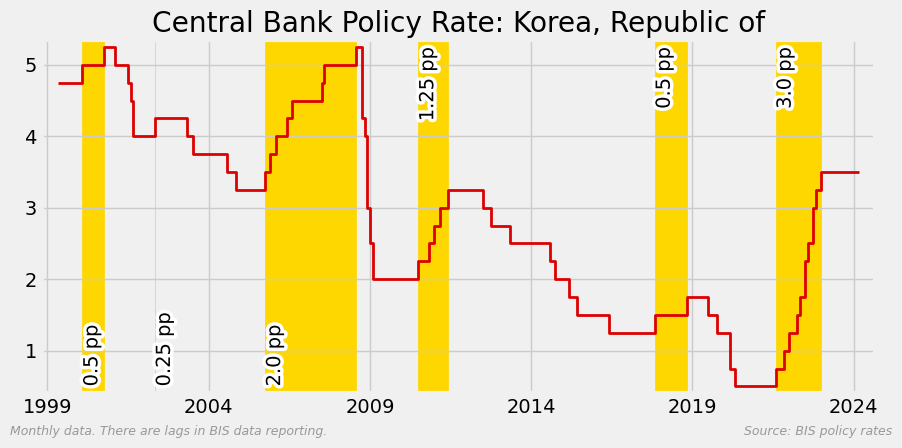

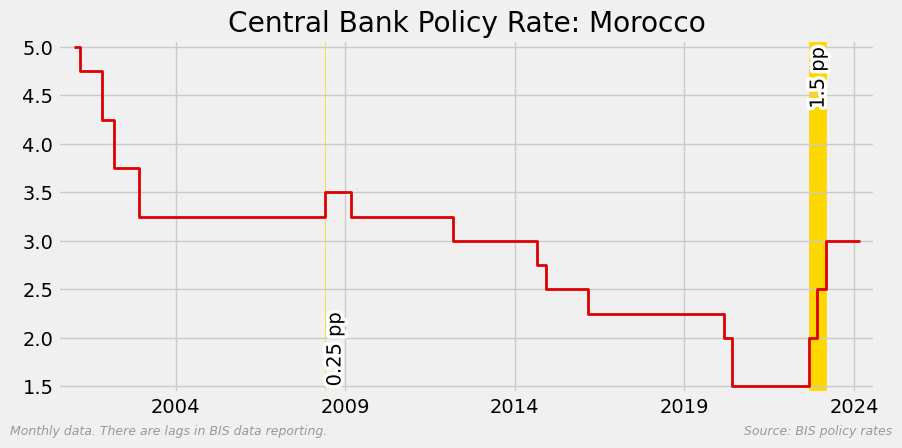

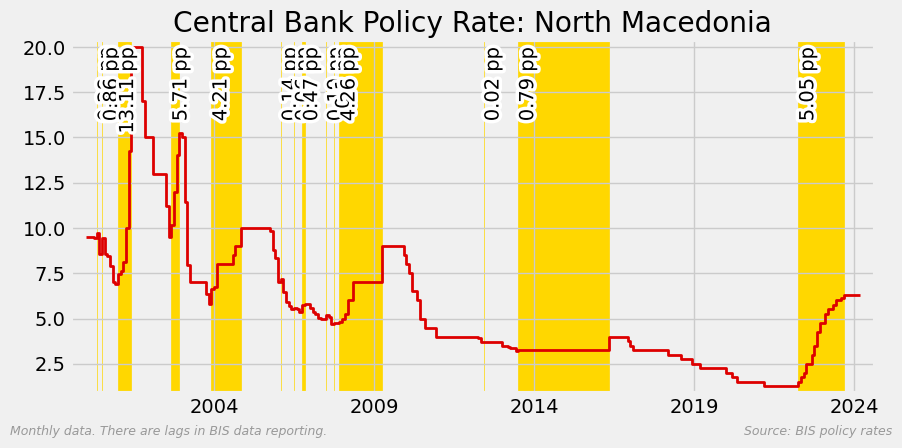

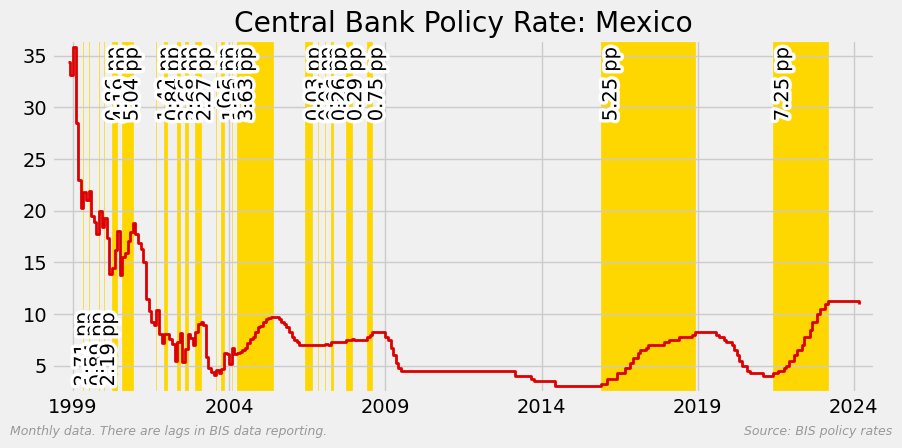

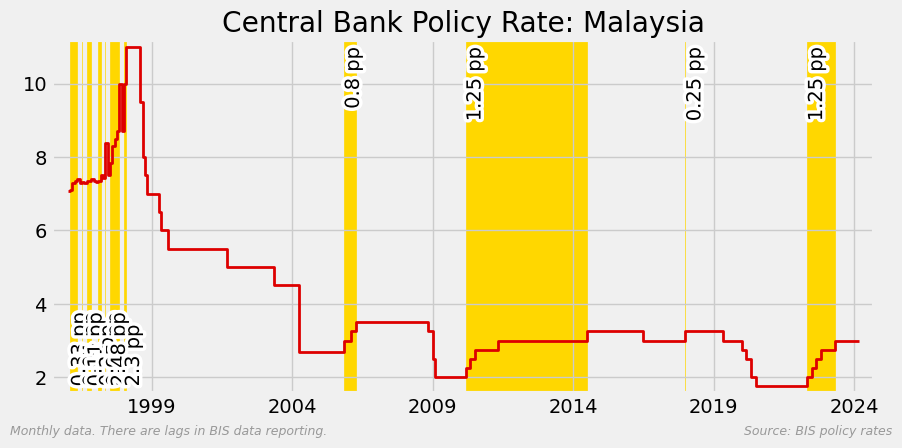

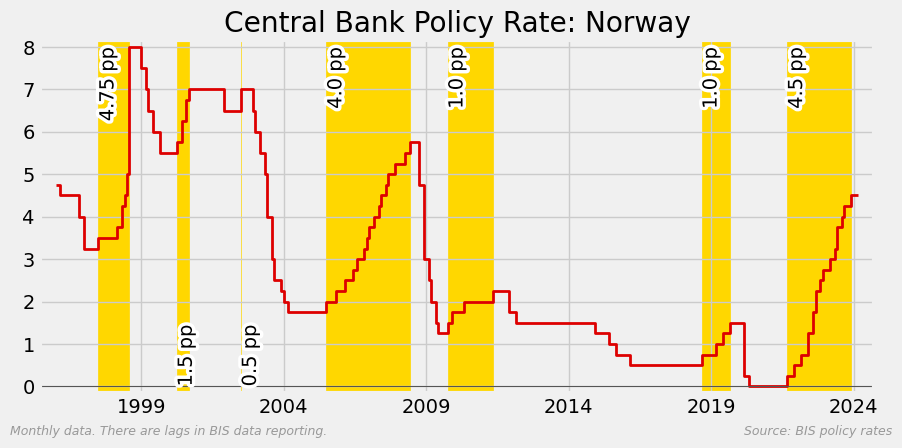

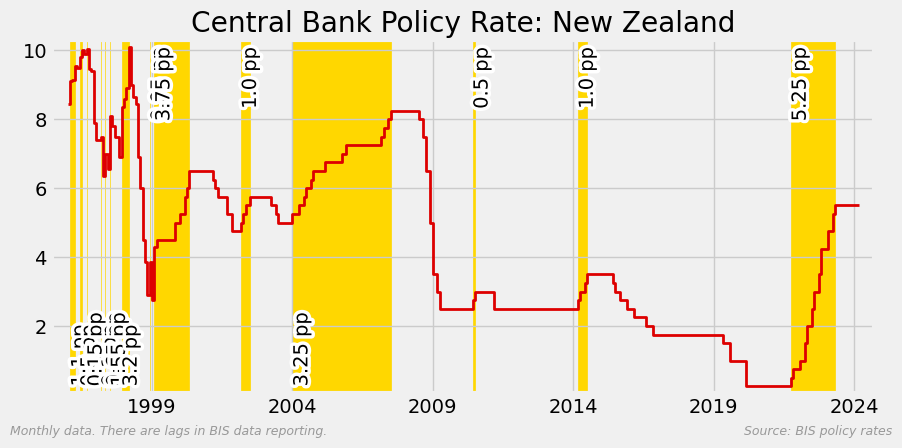

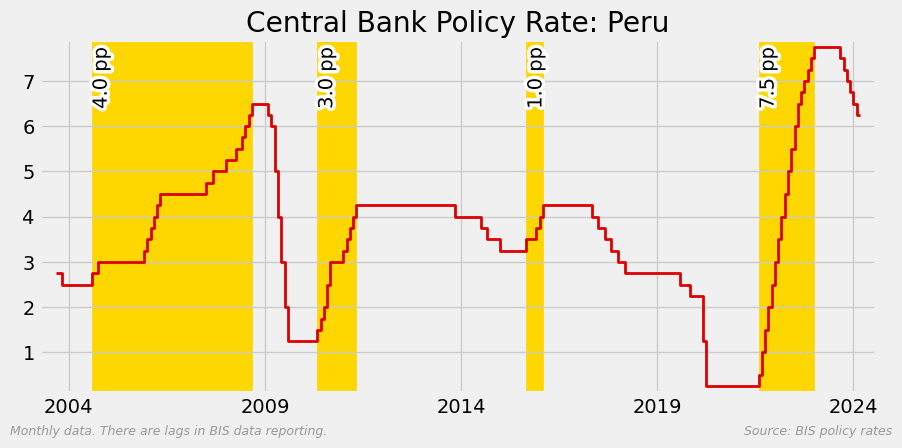

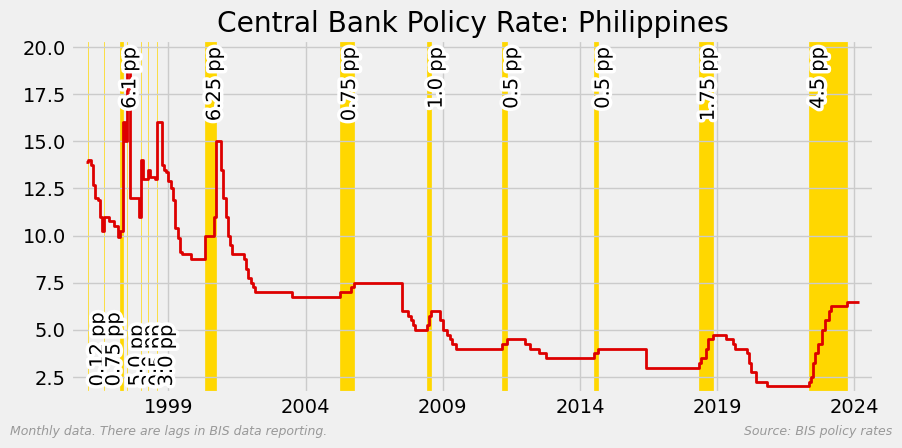

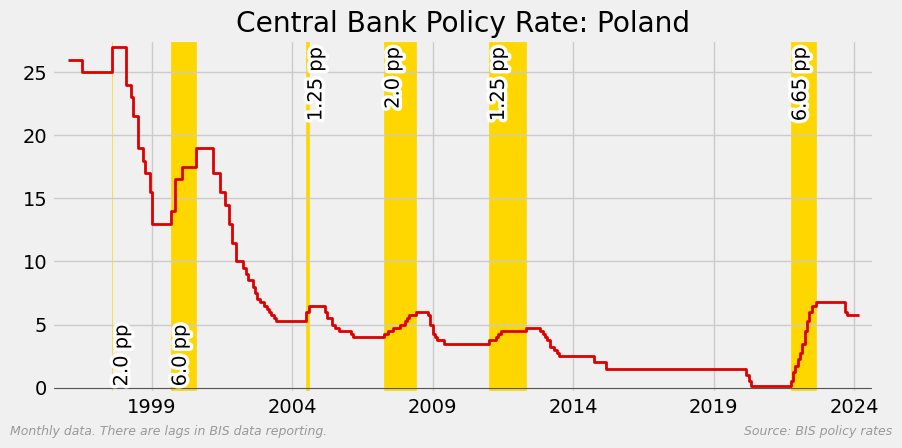

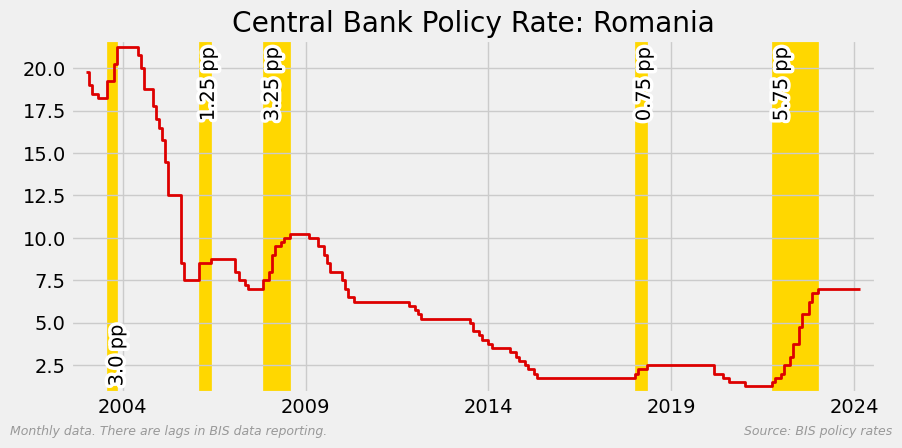

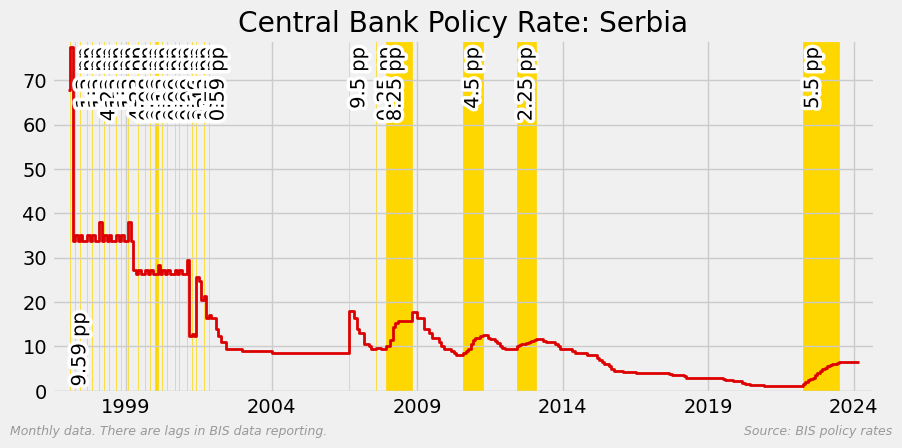

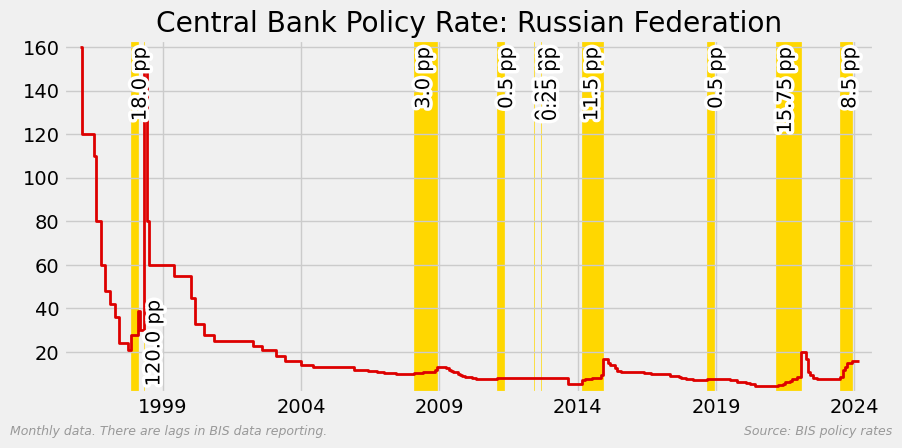

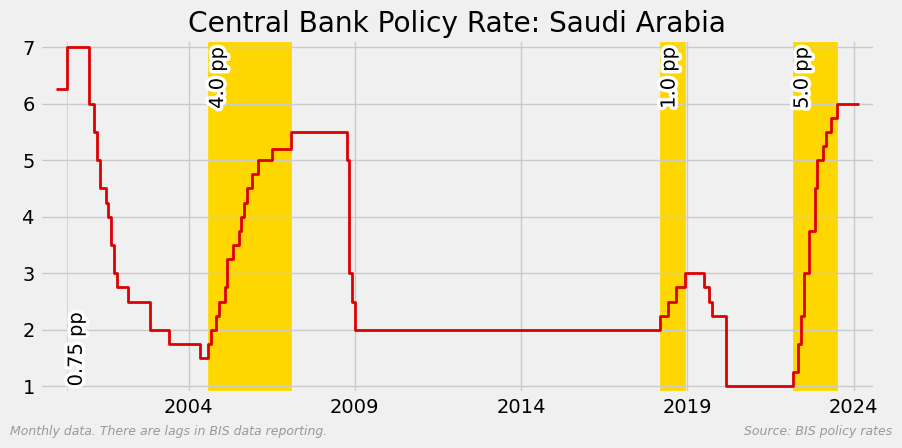

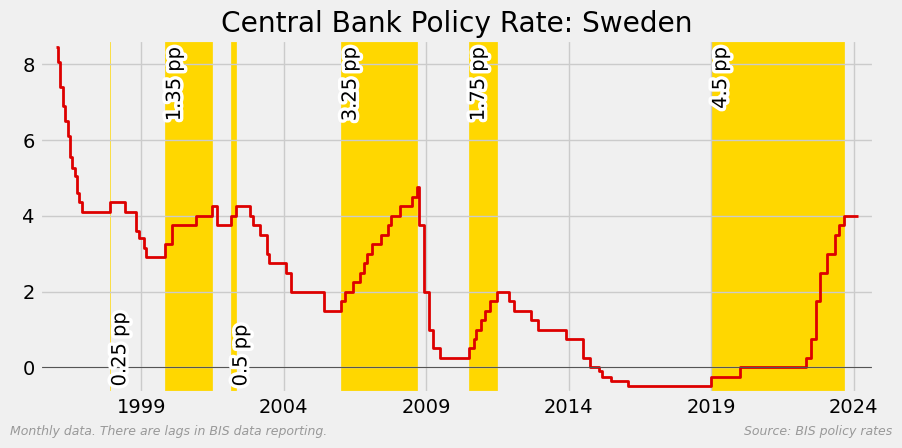

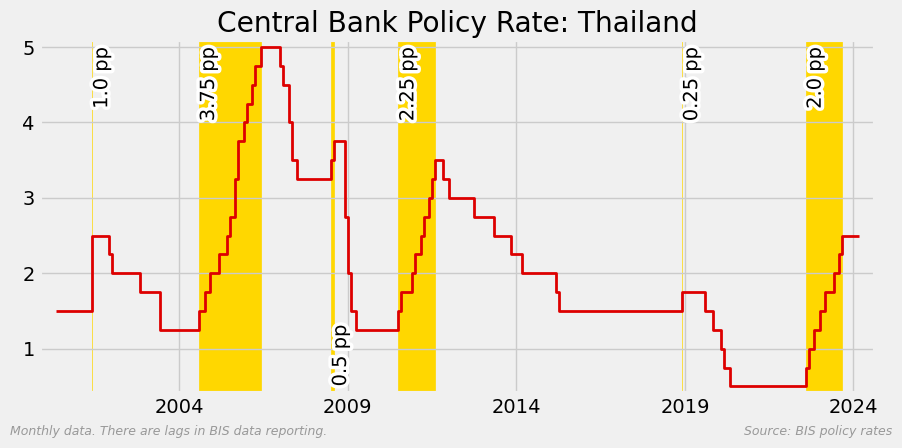

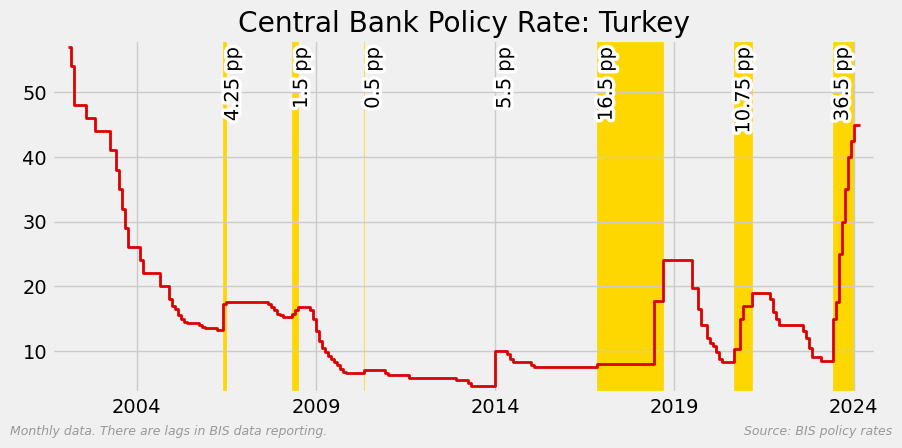

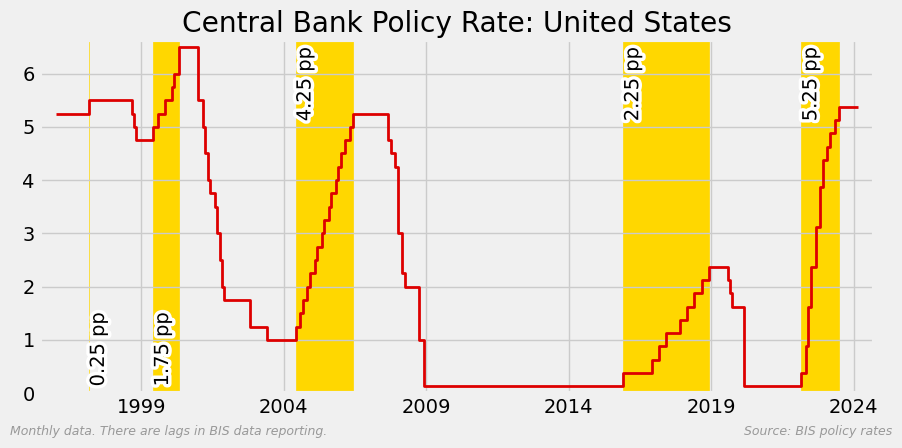

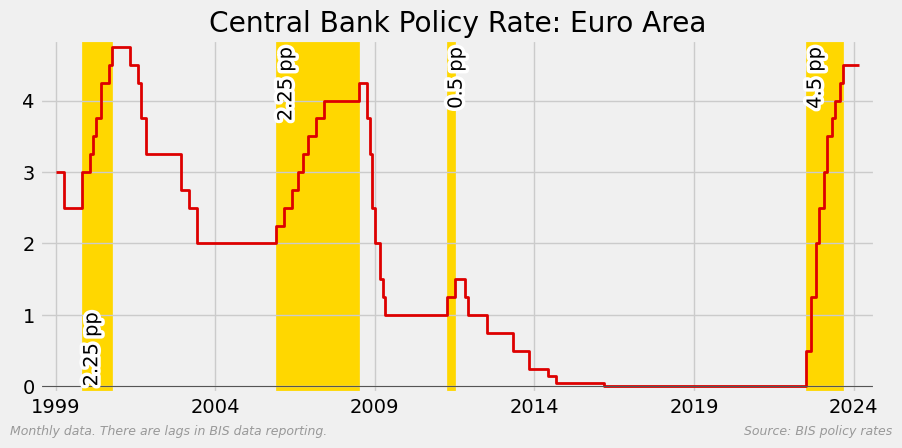

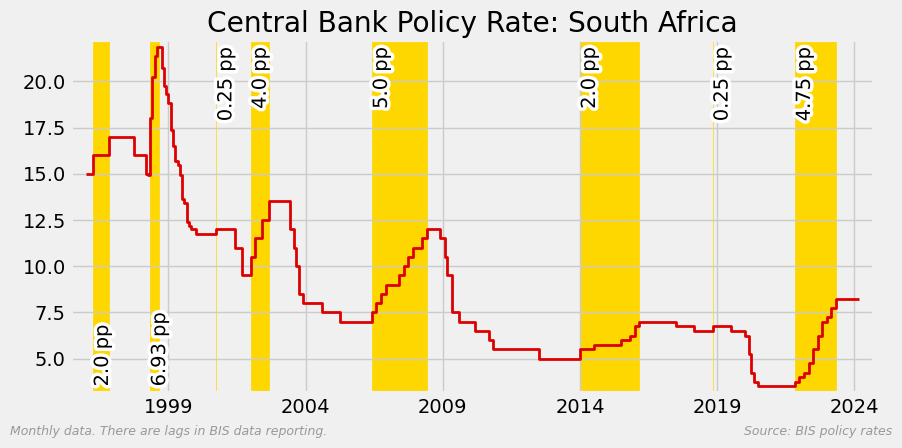

In [5]:
def plot_policy_rates(pr: pd.DataFrame):
    """Plot policy rates for all countries in the dataframe."""
    
    for col in pr.columns:
        series = pr[col]
        ax = plot_series_highlighted(series)
        finalise_plot(
            ax,
            y0=True,
            title=f"Central Bank Policy Rate: {col}", 
            rfooter=SOURCE, 
            lfooter=LFOOTER, 
            show=SHOW
            )
        

plot_policy_rates(policy_rates)

## The End

In [ ]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Mon Apr 01 2024 08:57:58

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

pandasdmx : 1.8.1
matplotlib: 3.8.3
numpy     : 1.26.4
pycountry : 22.3.5
pandas    : 2.2.1

Watermark: 2.4.3

